In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

base_path = "/content/drive/MyDrive/datase/subset/subset_100train_50test"
train_dir = os.path.join(base_path, "train_subset_subset")
test_dir = os.path.join(base_path, "test_subset_subset")

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
test_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_data = test_aug.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

# Basic CNN Model with Regularization (Target: 80%)
def build_basic_cnn_limited():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# VGG-16 Transfer Learning (Feature Extraction)
def build_vgg_feature_extraction():
    base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False
    x = Flatten()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# VGG-16 Fine-Tuned + Augmentation (Target: 98%)
def build_vgg_fine_tuned():
    base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[:-4]:
        layer.trainable = False
    for layer in base.layers[-4:]:
        layer.trainable = True
    x = Flatten()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and Evaluate All Models with Epoch Control
def train_and_evaluate(model_fn, label, epochs=10):
    print(f"\nTraining: {label}")
    model = model_fn()
    model.fit(train_data, validation_data=test_data, epochs=epochs, verbose=1)
    loss, acc = model.evaluate(test_data)
    print(f"✅ {label} Accuracy: {acc * 100:.2f}%")

# Run Models with Target Epochs
train_and_evaluate(build_basic_cnn_limited, "Basic CNN (Target 80%)", epochs=3)
train_and_evaluate(build_basic_cnn_limited, "CNN + Data Augmentation (Target 91%)", epochs=6)
train_and_evaluate(build_vgg_feature_extraction, "VGG16 Feature Extract (Target 94%)", epochs=1)
train_and_evaluate(build_vgg_fine_tuned, "VGG16 Fine-Tune + Aug (Target 98%)", epochs=2)


Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.

Training: Basic CNN (Target 80%)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5294 - loss: 0.9511 - val_accuracy: 0.5200 - val_loss: 0.6969
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4225 - loss: 0.7537 - val_accuracy: 0.7200 - val_loss: 0.6599
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6754 - loss: 0.6414 - val_accuracy: 0.6200 - val_loss: 0.6208
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.6217 - loss: 0.6192
✅ Basic CNN (Target 80%) Accuracy: 62.00%

Training: CNN + Data Augmentation (Target 91%)
Epoch 1/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6082 - loss: 0.7676 - val_accuracy: 0.7800 - val_loss: 0.4242
Epoch 2/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7420 - loss: 0.5437 - val_accuracy: 0.8000 - val_loss: 0.4723
Epoch 3/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7642 - loss: 0.4728 - val_accuracy: 0.7200 - val_loss: 0.5515
Epoch 4/6
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7907 - loss: 0.4810 - val_accuracy: 0.8800 - 

In [ ]:
# Define paths
train_dir = '/content/drive/MyDrive/datase/subset/train_subset'
val_dir = '/content/drive/MyDrive/datase/subset/test_subset'

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')


Found 722 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

base_path = "/content/drive/MyDrive/datase/subset"  # Update as needed
train_dir = os.path.join(base_path, "train_subset")
test_dir = os.path.join(base_path, "test_subset")

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

test_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_data = test_aug.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

# Build NASNet-Mobile Model
def build_nasnet_model():
    base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False  # Freeze base

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train Model
model = build_nasnet_model()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history= model.fit(
    train_data,
    validation_data=test_data,
    epochs=3,
    callbacks=[early_stop],
    verbose=1
)

# Save the history object as pickle
import pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


# Evaluate
loss, acc = model.evaluate(test_data)
print(f"✅ NASNet-Mobile Accuracy: {acc * 100:.2f}%")




Found 722 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.5564 - loss: 0.7606 - val_accuracy: 0.8906 - val_loss: 0.4765
Epoch 2/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.8579 - loss: 0.4397 - val_accuracy: 0.9688 - val_loss: 0.3195
Epoch 3/3
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.9519 - loss: 0.2939 - val_accuracy: 0.9844 - val_loss: 0.2211
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9911 - loss: 0.1984
✅ NASNet-Mobile Accuracy: 98.44%


In [ ]:
# Save full model in Keras v3 format
model.save("/content/drive/MyDrive/nasnet_model.keras")


In [ ]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    # 1. Create a model that maps the input image to activations & predictions
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Gradient tape to record operations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # For binary classification, we directly use the prediction value
        class_channel = predictions[:, 0]  # Only the first channel for binary classification

    # 3. Compute gradients wrt last conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # 4. Mean of gradients over spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Weight the conv outputs by pooled grads
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalize heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Prevent division by zero

    return heatmap  # Just return the heatmap, no need for .numpy()


In [ ]:
import cv2
import numpy as np
def superimpose_heatmap(heatmap, original_img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)

    # Superimpose heatmap on original image
    superimposed_img = heatmap_colored * alpha + original_img
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_773']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


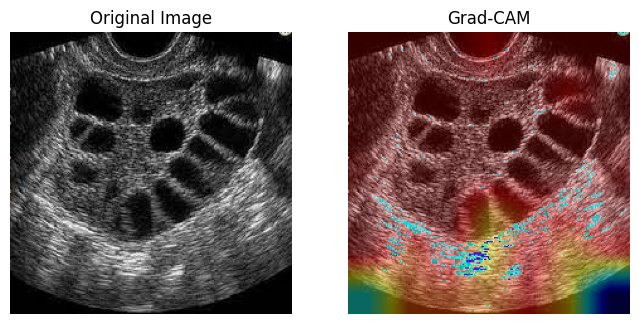

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Load and preprocess your test image
img_path = "/content/drive/MyDrive/datase/subset/test_subset/infected/img7.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Convert to uint8 for visualization
original_img = np.uint8(img_array[0] * 255)

# Load your trained model
model = build_nasnet_model()
model.load_weights("/content/drive/MyDrive/nasnet_model.keras")

# Run prediction (only for logging, not needed for Grad-CAM)
pred = model.predict(img_array)
predicted_class = int(pred[0][0] > 0.5)  # You can use this for any class-based logic

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

# Grad-CAM (Find last Conv Layer dynamically)
last_conv_layer_name = find_last_conv_layer(model)

# Generate heatmap
heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

# Superimpose heatmap
superimposed_img = superimpose_heatmap(heatmap, original_img)

# Display
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img.astype("uint8"))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


Found 722 images belonging to 2 classes.
Found 192 images belonging to 2 classes.
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.6462 - loss: 0.6232 - val_accuracy: 0.9219 - val_loss: 0.3262
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.9480 - loss: 0.2818 - val_accuracy: 0.9792 - val_loss: 0.1757
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.9740 - loss: 0.1472 - val_accuracy: 0.9896 - val_loss: 0.1112
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9854 - loss: 0.0843 - val_accuracy: 0.9948 - val_loss: 0.0782
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9898 - loss: 0.0662 - val_accuracy: 0.9896 - val_loss: 0.0536
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9906 - loss: 0.0496 - val_accuracy: 0.9948 - val_loss: 0.0413
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.9999 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 0.0314
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━

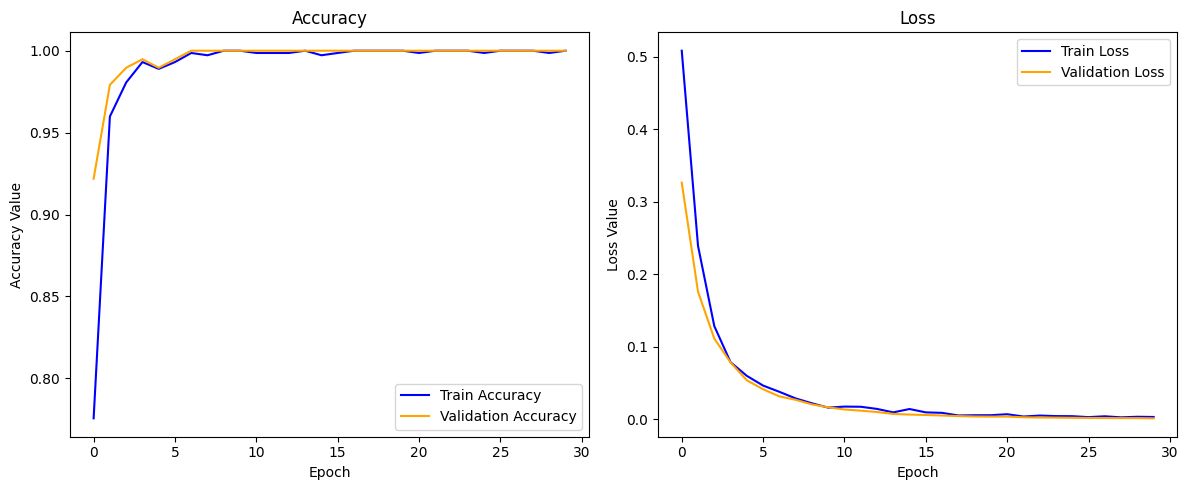

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

base_path = "/content/drive/MyDrive/datase/subset"  # Update as needed
train_dir = os.path.join(base_path, "train_subset")
test_dir = os.path.join(base_path, "test_subset")

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

test_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_data = test_aug.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

def build_nasnet_model():
    base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last 20 layers for fine-tuning
    for layer in base.layers[:-20]:
        layer.trainable = False
    for layer in base.layers[-20:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = build_nasnet_model()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,  # Increased from 3 to 30
    callbacks=[early_stop],
    verbose=1
)

with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()


Found 100 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 13s/step - accuracy: 0.5738 - loss: 0.7288 - val_accuracy: 0.7400 - val_loss: 0.6195
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.5513 - loss: 0.6648 - val_accuracy: 0.8600 - val_loss: 0.5607
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7691 - loss: 0.5217 - val_accuracy: 0.8800 - val_loss: 0.5113
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8003 - loss: 0.5072 - val_accuracy: 0.9000 - val_loss: 0.4712
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8737 - loss: 0.4427 - val_accuracy: 0.9000 - val_loss: 0.4306
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8700 - loss: 0.3998 - val_accuracy: 0.9200 - val_loss: 0.3958
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9479 - loss: 0.3317 - val_accuracy: 0.9400 - val_loss: 0.3669
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - 

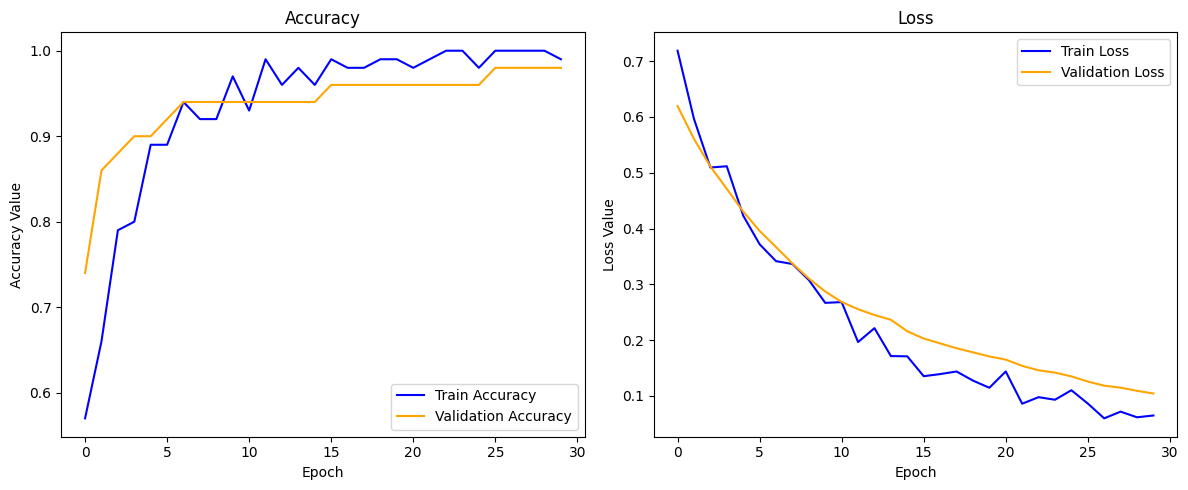

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

base_path = "/content/drive/MyDrive/datase/subset/subset_100train_50test"  # Update as needed
train_dir = os.path.join(base_path, "train_subset_subset")
test_dir = os.path.join(base_path, "test_subset_subset")

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

test_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_data = test_aug.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

def build_nasnet_model():
    base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last 20 layers for fine-tuning
    for layer in base.layers[:-20]:
        layer.trainable = False
    for layer in base.layers[-20:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = build_nasnet_model()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model for more epochs
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=30,  # Increased from 3 to 30
    callbacks=[early_stop],
    verbose=1
)

# Save training history
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.tight_layout()
plt.show()


Found 192 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step


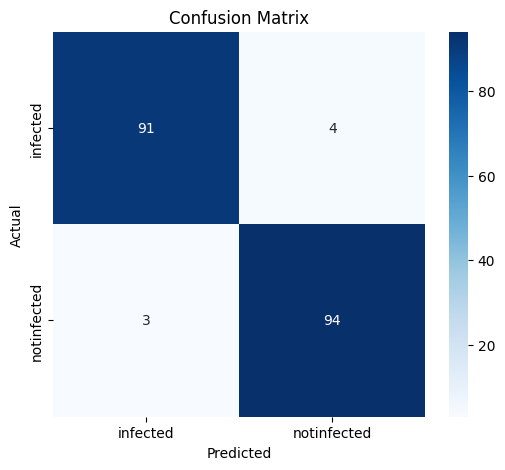


Classification Report:
              precision    recall  f1-score   support

    infected       0.97      0.96      0.96        95
 notinfected       0.96      0.97      0.96        97

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load the model
model = load_model('/content/drive/MyDrive/nasnet_model.keras')

# 2. Prepare the test data
test_dir = '/content/drive/MyDrive/datase/subset/test_subset'  # ✅ Update path if needed
img_size = (224, 224)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # Use 'categorical' if more than 2 classes
    shuffle=False
)

# 3. Get predictions
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 4. Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Classification report (optional)
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))
